# INITIAL MODEL EXPLORATION: CREATOR AS CUSTOMER

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, gradient_boosting
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ridge_regression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
kick_proc = pd.read_pickle('../../data/03_processed/kick_proc.pkl')

In [4]:
kick_proc.head()

,currency,goal_original,category,country,blurb_word_count,campaign_length,delta_created_launched,goal_usd,successful_dummy,world_regions
0,USD,5000.0,Tabletop Games,US,9.0,32,13,5000.0,1,Northern America
1,USD,3500.0,Music,US,14.0,18,1,3500.0,1,Northern America
2,USD,500.0,Zines,US,17.0,15,1,500.0,1,Northern America
3,USD,6800.0,Graphic Novels,US,12.0,30,6,6800.0,1,Northern America
4,USD,600.0,Mixed Media,US,19.0,30,0,600.0,1,Northern America


## DATASET SET-UP

### Let's set up our X and y values

We won't need these values for logistic regression so let's drop them now

In [5]:
kick_logm = kick_proc.drop(columns=['currency', 'goal_original', 'country'])

In [6]:
y = kick_logm['successful_dummy'].values

Great, now that we have our target variable we can drop that from our dataframe

In [7]:
df_drop_y = kick_logm.drop(columns=['successful_dummy'])

Most Kickstarter campaign goals are below XXX dollars. Let's take the log and see if it will be approximately normally distributed. 

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


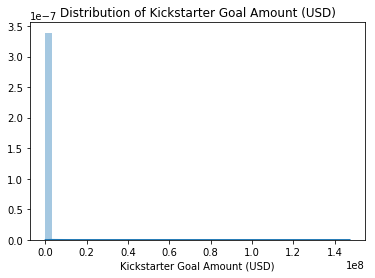

In [8]:
sns.distplot(df_drop_y['goal_usd'])
plt.title('Distribution of Kickstarter Goal Amount (USD)')
plt.xlabel('Kickstarter Goal Amount (USD)')
plt.show()

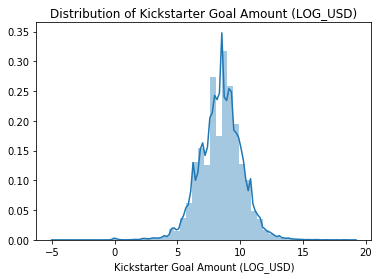

In [9]:
sns.distplot(np.log(df_drop_y['goal_usd']))
plt.title('Distribution of Kickstarter Goal Amount (LOG_USD)')
plt.xlabel('Kickstarter Goal Amount (LOG_USD)')
plt.show()

In [10]:
goal_log = np.log(df_drop_y['goal_usd'])

In [11]:
df_drop_y['goal_usd_log'] = goal_log

In [12]:
X_feats = ['category', 'blurb_word_count', 'campaign_length', 'delta_created_launched', 'world_regions', 'goal_usd_log']

In [13]:
X = pd.get_dummies(df_drop_y[X_feats]).values

Let's set up our log

### TRAIN, TEST, SPLIT

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

## LOGISTIC REGRESSION

In [15]:
logrc = LogisticRegression()

In [16]:
logrc.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
logrc.score(X_test, y_test)

0.7517087257477035

In [18]:
y_pred = logrc.predict(X_test)

In [19]:
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                           index = ['actual 0', 'actual 1'], 
                           columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,25651,6614
actual 1,10496,26150


In [20]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.71      0.80      0.75     32265\n           1       0.80      0.71      0.75     36646\n\n    accuracy                           0.75     68911\n   macro avg       0.75      0.75      0.75     68911\nweighted avg       0.76      0.75      0.75     68911\n'

## NAIVE BAYES CLASSIFIER

All versions of naive bayes were attempted, but a number does not allow negative values. 

### Initial Models

#### Gaussian Naive Bayes

In [21]:
nbcG = GaussianNB()

In [22]:
nbcG.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [27]:
nbcG.score(X_test, y_test)

0.7213507277502866

#### Bernoulli Naive Bayes

In [31]:
nbcB = BernoulliNB()

In [32]:
nbcB.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [33]:
nbcB.score(X_test, y_test)

0.7357315958265008

### Random/ Grid Search for Best Models